# Modeling the 20C Hansard Debates on the Environment with word2vec

For this Notebook we will use a subset of the 20th-century Hansard Parliamentary Debates made up of just debates with the words, "environment", "clean water", "clean air" or "climate" in their title. While these debates do not form the entire corpus of Hansard's 20th-century debates on the environment, they can provide insight into how environmental discourse changed in parliament over time. 

The first 20th-century debate with a keyword in its title was in May of 1965. The last was in December of 1999. To analyze change over time, our corpus breaks this time range into two, 20(ish)-year periods: the 1960s through the 1970s, and the 1980s through the 1990s. 

From this corpus we will construct a "model"--that is, a data set trained to look for particular patterns--using `word2vec`. `word2vec` is used to produce word embeddings, where vocabulary is mapped to numbers. `word2vec`'s algorithm uses a neural network model to learn word associates from a large corpus of text.

### Importing Modules

We will start by importing our modules. `gensim` provides word2vec, while objects from `nltk` will help us tokenize the debate text. 

In [1]:
import gensim 
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer

We are also going to import `pprint` for "pretty print," and write a function that will allow us to print clearer, shorter dictionaries, making their contents easier to inspect. 

In [2]:
import pprint

def printDict(dict_object):
    truncated_dict = dict(list(dict_object.items())[0:20])
    pprint.pprint(truncated_dict)

### Hansard: 1960s and 70s

Now let's read in the Hansard data. Our first model will includes debates from the 1960s through the 1970s.

In [3]:
file_path = '/scratch/group/history/hist_3368-jguldi/hansard_c20/'

In [4]:
with open(file_path + "hansard_c20_1960_70.txt") as f:
    debate_text_1960_70 = [line.rstrip('\n') for line in f][1:]

Printing the first 10 lines returns a list where each sentence is a separate character string.

In [5]:
debate_text_1960_70[:10]

['"3. asked the Secretary of State for Education and Science what steps he is taking to ensure that the Natural Environment Research Council gives added emphasis to military oceanography, as stated in the Defence White Paper."',
 'The Natural Environment Research Council is not responsible for research in oceanography directed specifically to military purposes.',
 '"This is the responsibility of the Ministry of Defence, and the Defence White Paper refers to added emphasis being given to military oceanography by the Ministry of Defence."',
 '"In the field of basic research, there will be a common interest and arrangements are therefore envisaged which will provide for representation of the Ministry on the appropriate Committees of the Research Council."',
 'Is not the right hon.',
 '"Gentleman now generally responsible for the National Institute of Oceanography and its work, and is it not self-evident that the reduced responsibility of the Ministry of Defence for this Council will tend 

We can borrow Sinykin's `make_sentences()` function to create a vocabulary on which to train our ML model.

In [6]:
tokenizer = TreebankWordTokenizer()

def make_sentences(text):
    preprocessed_text = []
    for line in text:
        lower_case = line.lower()
        sentences = sent_tokenize(lower_case)
        tokenized_sentences = [tokenizer.tokenize(sent) for sent in sentences]
        preprocessed_text += tokenized_sentences
    return preprocessed_text

Let's explore the structural output of `make_sentences()` in greater detail so we understand what we are giving word2vec to train. With this understanding, you can easily train your own model. 

In [7]:
sentences_1960_70 = make_sentences(debate_text_1960_70)

In [8]:
print(sentences_1960_70[:2]) 

[['``', '3.', 'asked', 'the', 'secretary', 'of', 'state', 'for', 'education', 'and', 'science', 'what', 'steps', 'he', 'is', 'taking', 'to', 'ensure', 'that', 'the', 'natural', 'environment', 'research', 'council', 'gives', 'added', 'emphasis', 'to', 'military', 'oceanography', ',', 'as', 'stated', 'in', 'the', 'defence', 'white', 'paper', '.', "''"], ['the', 'natural', 'environment', 'research', 'council', 'is', 'not', 'responsible', 'for', 'research', 'in', 'oceanography', 'directed', 'specifically', 'to', 'military', 'purposes', '.']]


`sentences` is a list of lists. One large list holds many small lists, and within each small list are the tokens making up a sentence. These tokens will serve as the vocabulary words used to train our model. 

In [9]:
hansard_model_1960_70 = gensim.models.Word2Vec(
    sentences_1960_70,
    min_count = 2, # remove words stated only once
    size = 200) # size of neuralnet layers; default is 100; higher for larger corpora

Let's also save our model in case we want to use it again in a later session.

In [10]:
hansard_model_1960_70.save('hansard_model_1960_70')
# hansard_model = gensim.models.Word2Vec.load('hansard_model') # to load a saved model

The trained word vectors are stored in a `KeyedVectors` instance named `model.wv`. Separating the trained vectors into `KeyedVectors` returns a much smaller and faster object than the whole data set. 

Let's use the `printDict()` function we defined earlier and inspect `hansard_model_1960_70`.

In [10]:
printDict(hansard_model_1960_70.wv.vocab)

{'``': <gensim.models.keyedvectors.Vocab object at 0x2aaaae2df130>,
 'and': <gensim.models.keyedvectors.Vocab object at 0x2aaacdc7ea00>,
 'asked': <gensim.models.keyedvectors.Vocab object at 0x2aaaae0d6520>,
 'education': <gensim.models.keyedvectors.Vocab object at 0x2aaacdc7e850>,
 'ensure': <gensim.models.keyedvectors.Vocab object at 0x2aaacdcc70d0>,
 'environment': <gensim.models.keyedvectors.Vocab object at 0x2aaacdcc7250>,
 'for': <gensim.models.keyedvectors.Vocab object at 0x2aaacdc7e400>,
 'he': <gensim.models.keyedvectors.Vocab object at 0x2aaacdcc7ac0>,
 'is': <gensim.models.keyedvectors.Vocab object at 0x2aaacdcc7850>,
 'natural': <gensim.models.keyedvectors.Vocab object at 0x2aaacdcc71f0>,
 'of': <gensim.models.keyedvectors.Vocab object at 0x2aaacdc7ef10>,
 'science': <gensim.models.keyedvectors.Vocab object at 0x2aaacdc7ed60>,
 'secretary': <gensim.models.keyedvectors.Vocab object at 0x2aaacdc7efa0>,
 'state': <gensim.models.keyedvectors.Vocab object at 0x2aaacdc7ed00>,
 's

### Determining Similarity in Word Meaning

We can invoke the `most_similar()` method on our model to see which words word2vec has determined are most similar in meaning to one-another.

The following code returns the top 10 words determined to be most similar to the word "environment" based on our training vocabulary.

In [31]:
hansard_model_1960_70.wv.most_similar("environment", topn = 10)

[('protection', 0.7790396809577942),
 ('nature', 0.7429018616676331),
 ('environmental', 0.7369294166564941),
 ('research', 0.7196264863014221),
 ('responsibility', 0.7156100869178772),
 ('scotland', 0.7137181758880615),
 ('ministry', 0.7110477685928345),
 ('effects', 0.6995458602905273),
 ('world', 0.6984202265739441),
 ('law', 0.6951407790184021)]

Compare this yield with the words determined most similar to "sewage." 

In [124]:
hansard_model_1960_70.wv.most_similar("sewage", topn = 10)

[('effluent', 0.9528419971466064),
 ('works', 0.9365886449813843),
 ('treatment', 0.9311678409576416),
 ('smoke', 0.9103373289108276),
 ('discharged', 0.9098536968231201),
 ('polluting', 0.8948899507522583),
 ('controlled', 0.8946700692176819),
 ('commercial', 0.8914747834205627),
 ('poisonous', 0.890518307685852),
 ('refuse', 0.8862885236740112)]

### Analogies

`word2vec` can also return analogies in a corpus. To determine similarity in word meaning through analogy, we can supply three words and `word2vec` will determine the last. 

The following arguments can be read like so: "Britain is to smoke as sea is to X" where "X" is determined by `word2vec`. 

In [40]:
result = hansard_model_1960_70.wv.most_similar(positive=['sea', 'smoke'], negative=['britain']) # remember we transformed all words to lowercase 

In [41]:
print("{}: {:.4f}".format(*result[0])) # returns just the first result, formatted to read clearly

oil: 0.7733


According to our model, Britain is to smoke as sea is to oil. Based on our training set, word2vec returns an analogy that makes sense: smoke is a pollutant of Britain as oil is a pollutant of water. 

### Visualizing our Analogy

The four words making up the analogy can be understood as points in space where each word represents a single point. These points represent words' relationships with one-another.

Let's borrow more of Sinykin's code to visualize the results.

In [49]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

In [52]:
#%matplotlib inline

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

<ipython-input-52-72619a12c7c4>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word_vectors = np.array([model[w] for w in words])


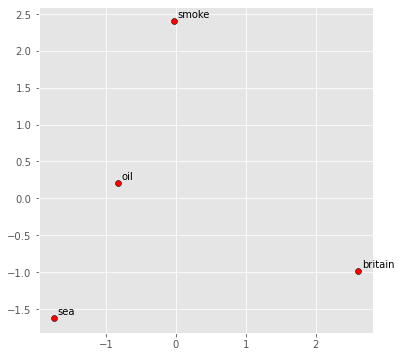

In [53]:
display_pca_scatterplot(hansard_model_1960_70, ['britain','smoke','sea','oil']) # remember we transformed all words to lowercase

As shown in the above plot, oil is closer in space to sea than Britain, indicating a meaningful relationship. Likewise, smoke is closer to Britain than sea. However, smoke is closer to oil than Britain, suggesting both smoke and oil share a relationship. We can confirm they do, as they are both described as pollutants in these debates.

### Limitations of our Model and word2vec

Both `word2vec` and our model have limitations.

`word2vec`'s analogies often make the most sense when the word usage of the training set reflects binary thinking. `word2vec` shines when returning results for analogies like " King : Queen :: Man : X", but has been noted to return confusing results for words with usages that are not generally assigned to a binary, like apple : green :: banana : X.

Additionally, our training set is selective and small (just a subset of some debates about the environment). Therefore, our analogies can return some wild cards. 

The following analogy reads: "water is to chemicals as air is to X."

In [74]:
result = hansard_model_1960_70.wv.most_similar(positive=['air', 'chemicals'], negative=['water']) 

In [75]:
for r in range(5):
    print("{}: {:.4f}".format(*result[r])) # returns just the first five results, formatted to read clearly

substances: 0.8304
dirty: 0.8231
midlands: 0.8135
pollutants: 0.8081
coastal: 0.8078


The words "substances", "dirty", and "pollutants" makes sense, but without more context, "midlands" and "coastal" seem like they do not belong.

While our training set has drawbacks, comparing results from different time periods can still be insightful. 

### Hansard: 1980 to 1990

We can perform these same operations on our other data set, debates from the 1980s through the 1990s, for the purpose of analyzing language change over time.

Note: this model will take a little longer to process because our data set is slightly larger.

In [138]:
with open(file_path + 'hansard_c20_1980_90.txt') as f:
    debate_text_1980_90 = [line.rstrip('\n') for line in f][1:]

In [140]:
sentences_1970_90 = make_sentences(debate_text_1980_90)

In [142]:
hansard_model_1980_90 = gensim.models.Word2Vec(
    sentences_1980_90,
    min_count = 2, 
    size = 200, 
    workers = 5)

Worthy of further research is the observation that "warming" appears in `hansard_model_1980_90`.

In [143]:
hansard_model_1980_90.wv.most_similar("environment", topn = 10)

[('environmental', 0.5770868062973022),
 ('consumer', 0.49735119938850403),
 ('warming', 0.48056459426879883),
 ('employment', 0.4719513952732086),
 ('science', 0.4586169719696045),
 ('birds', 0.4468916952610016),
 ('transport', 0.43481749296188354),
 ('nature', 0.4347519874572754),
 ('society', 0.4267409145832062),
 ('agriculture', 0.42662715911865234)]

`word2vec` determined that many of the top most words related to "environment" in the 1980s and 1990s had to do with technological growth (like "employment", "society", "agriculture", and "science"), compared to the 1960s through the 1970s, where top words included "protection", "nature", and "responsibility."

In [76]:
hansard_model_1960_70.wv.most_similar("environment", topn = 10)

[('protection', 0.7790396809577942),
 ('nature', 0.7429018616676331),
 ('environmental', 0.7369294166564941),
 ('research', 0.7196264863014221),
 ('responsibility', 0.7156100869178772),
 ('scotland', 0.7137181758880615),
 ('ministry', 0.7110477685928345),
 ('effects', 0.6995458602905273),
 ('world', 0.6984202265739441),
 ('law', 0.6951407790184021)]

We can also compare the top words determined to be most similar to "Britain" for the 1980s through the 1990s with the top words for the 1960s through the 1970s.

In [149]:
hansard_model_1980_90.wv.most_similar("britain", topn = 10) # remember we transformed all words to lowercase 

[('world', 0.6584057211875916),
 ('europe', 0.6561944484710693),
 ('poland', 0.6229649782180786),
 ('nation', 0.5565208792686462),
 ('region', 0.5420501232147217),
 ('population', 0.5408176779747009),
 ('uk', 0.5318464040756226),
 ('mankind', 0.5081990957260132),
 ('women', 0.5075250864028931),
 ('unemployment', 0.4989219903945923)]

In [77]:
hansard_model_1960_70.wv.most_similar("britain", topn = 10)

[('city', 0.8222301602363586),
 ('kew', 0.8148987889289856),
 ('increasing', 0.808451771736145),
 ('places', 0.8046635389328003),
 ('character', 0.8034182190895081),
 ('spread', 0.8029613494873047),
 ('growth', 0.7947773337364197),
 ('activity', 0.7877945899963379),
 ('potential', 0.7872251272201538),
 ('counties', 0.7849066257476807)]

From these results alone, it appears that earlier discourses explicitly discussed Britain's local growth, while later discourses about Britain were directed to global concerns. 

Analogies can also lend insight to discourses in the 1980s through the 1990s. The following analogy reads: "shipyard is to ship as sea is to X." 

In [154]:
result = hansard_model_1980_90.wv.most_similar(positive=['sea', 'ship'], negative=['shipyard'])

print("{}: {:.4f}".format(*result[0])) # this prints the top result

sewage: 0.6663


Like ships how ships are found in a shipyard, sewage is found in the sea.

### Your Turn

Now it's your turn to use word2vec to determine which words are most similar in meaning to one-another. Remembering that our model is a subset of debates about the environment, it may be most insightful to try words like "nature" or "countryside." 

Note, however, that your neural network might make different decisions that will yield different results than the model used by this Notebook, even if provided with the same analogy. One drawback to neural networks is that the decisions made to arrive at a model aren't easily traced. 